In [ ]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import scipy as sp
import scipy.integrate

In [46]:
sigma = 10
rho = 28
beta = 8/3
n_data = 10000

input_t = np.arange(0., 1, 0.02)
init = np.random.uniform(low=-1., high=1., size=(n_data, 3))
def f(t, y): return np.array([sigma * (y[1] - y[0]), y[0]*(rho - y[2]) - y[1], y[0]*y[1] - beta*y[2]])
sol_data = np.empty((n_data, 3, input_t.shape[0]))

for i in range(n_data):
    sol = sp.integrate.solve_ivp(f, [0, input_t[-1]], init[i, :], t_eval = input_t)
    sol_data[i, :, :] = sol.y
    
Coeff = 0.5
train_data = sol_data[:int(Coeff*n_data), :, :]

test_data = sol_data[int(Coeff*n_data)::, :]

In [6]:
train_data = np.load("train_data.npy")
test_data = np.load("test_data.npy")

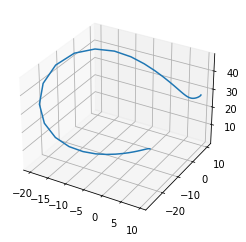

In [7]:
ax = plt.axes(projection='3d');
ax.plot3D(train_data[-1, 0, :], train_data[-1, 1, :], train_data[-1, 2, :],);

In [48]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from keras.layers import Input

In [165]:
nt = input_t.shape[0]
latent_dim = 3 

first_ = Input(shape=(3, nt))
def encoder_one(inp):
    second_ = layers.Dense(30 , activation='relu')(inp)
    third_ = layers.Dense(30, activation='relu')(second_)
    last_ = layers.Dense(latent_dim, activation='relu')(third_)
    return last_

def linear_one(inp):
    
    last = layers.Dense(latent_dim)(inp)
    return last

def decoder_one(inp):
    third = layers.Dense(30, activation='relu')(inp)
    second = layers.Dense(30, activation='relu')(third)
    first = layers.Dense(3, activation='relu')(second)
    return first

def encoder(inp):
    encoded = []
    for i in range(inp.shape[2]):
        encoded.append(encoder_one(inp[:, :, i]))
    return encoded

def linear(inp):
    advanced = []
    for i in range(len(inp)):
        advanced.append(linear_one(inp[i]))
    return advanced

def decoder(inp):
    decoded = []
    for i in range(len(inp)):
        decoded.append(decoder_one(inp[i]))
    return tf.stack(decoded, axis=2)

enc = encoder(first_)
adv = linear(enc)
dec = decoder(adv)


model = Model(inputs=first_, outputs=dec)

In [164]:
tf.config.run_functions_eagerly(True)

In [166]:
def recon_loss(y_true, y_pred):
    squ_diff = tf.square(y_true[:, :, 0] - decoder_one(encoder_one(y_pred[:, :, 0])))
    return tf.reduce_mean(squ_diff, axis=1)

def pred_loss(y_true, y_pred):
    #a = tf.zeros([y_true.shape[0], y_true.shape[1], 30])
    a = [decoder_one(linear_one(encoder_one(y_true[:, :, 0])))]
    for i in range(29):
        a.append(decoder_one(linear_one(encoder_one(a[-1]))))    
    b = tf.square(y_pred[:, :, :30] - tf.stack(a, axis=2))
    return tf.reduce_mean(tf.reduce_mean(b, axis=1), axis=1)

def lin_loss(y_true, y_pred):
    a = [linear_one(encoder_one(y_true[:, :, 0]))]
    for i in range(nt-2):
        a.append(linear_one(encoder_one(a[-1])))
    b = tf.square(tf.stack(encoder(y_pred[:, :, 1::]), axis=2) - tf.stack(a, axis=2))
    return tf.reduce_mean(tf.reduce_mean(b, axis=1), axis=1)

def inf_loss(y_true, y_pred):
    a = tf.norm((y_true[:, :, 0] - decoder_one(encoder_one(y_pred[:, :, 0]))), axis = 1, ord=np.inf)
    b = tf.norm((y_true[:, :, 1] - decoder_one(encoder_one(linear_one(y_pred[:, :, 0])))), axis = 1, ord=np.inf)
    return a+b

def custom_loss_function(y_true, y_pred):
    alpha1=0.1
    alpha2=1e-7
    return alpha1*(recon_loss(y_true, y_pred)+pred_loss(y_true, y_pred)) + lin_loss(y_true, y_pred) + alpha2 * inf_loss(y_true, y_pred)

In [146]:
def custom_loss_function(y_true, y_pred):
    print(y_true.shape)
    print(y_pred.shape)
    squared_difference = tf.square(decoder_one(encoder_one(y_true[:, :, 0])) - y_pred[:, :, 1])
    return tf.reduce_mean(squared_difference, axis=-1)

In [167]:
model.compile(optimizer='adam', loss=custom_loss_function)

In [ ]:
model.fit(train_data, train_data,
                epochs=10,
                shuffle=True,
                validation_data=(test_data, test_data));

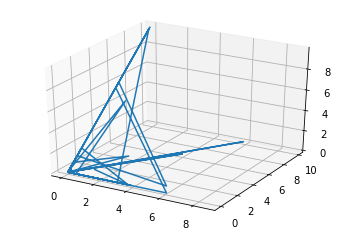

In [173]:
ax = plt.axes(projection='3d');
ss = tf.stack(encoder(train_data), axis=2)
ax.plot3D(ss[-1, 0, :], ss[-1, -1, :], ss[-1, 2, :],);

In [8]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [10]:
train_data = torch.from_numpy(train_data).float()
train_data = torch.nn.functional.normalize(train_data, p=2.0, dim = 2)

test_data = torch.from_numpy(test_data).float()
test_data = torch.nn.functional.normalize(test_data, p=2.0, dim = 2)

Epoch 1 		 Training Loss: 0.007500954574631942 		 Validation Loss: 0.0021699187791130955
Epoch 2 		 Training Loss: 0.0021638288425999234 		 Validation Loss: 0.0021699187791130955
Epoch 3 		 Training Loss: 0.0021638288425999234 		 Validation Loss: 0.0021699187791130955
Epoch 4 		 Training Loss: 0.0021638288425999234 		 Validation Loss: 0.0021699187791130955
Epoch 5 		 Training Loss: 0.0021638288425999234 		 Validation Loss: 0.0021699187791130955
Epoch 6 		 Training Loss: 0.0021638288425999234 		 Validation Loss: 0.0021699187791130955


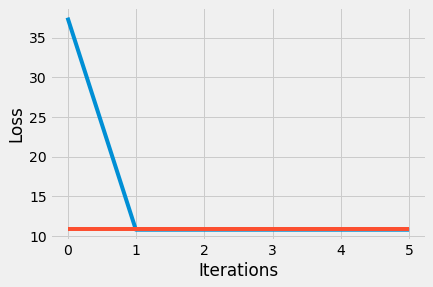

In [11]:
epochs = 6
outputs = []
losses = []
valid_losses = []
losses_recon = []
losses_pred = []
losses_lin = []
losses_inf = []

alpha1 = 0.1
alpha2 = 1e-7
alpha3 = 1e-15
Sp = 30

nt = train_data.shape[2]
train_size = train_data.shape[0]
val_size = test_data.shape[0]

class AE(torch.nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder_one = torch.nn.Sequential(
            torch.nn.Linear(3, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 3),
            torch.nn.ReLU(),
        )
 
        self.linear_one = torch.nn.Linear(3, 3)
        self.decoder_one = torch.nn.Sequential(
            torch.nn.Linear(3, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 3),
            torch.nn.ReLU(),
        )
 

    def forward(self, x):
        def encoder(inp):
            encoded = []
            for i in range(inp.shape[1]):
                encoded.append(self.encoder_one(inp[:, i]))
            return encoded

        def linear_(inp):
            advanced = []
            for i in range(len(inp)):
                advanced.append(self.linear_one(inp[i]))
            return advanced

        def decoder(inp):
            decoded = []
            for i in range(len(inp)):
                decoded.append(self.decoder_one(inp[i]))
            return torch.stack(decoded, axis=1)

        encoded = encoder(x)
        advanced = linear_(encoded)
        decoded = decoder(advanced)

        return encoded, advanced, decoded

# Model Initialization
model = AE()
  
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.001,
                             weight_decay = alpha3)

def recon_loss(y_true, encoded_y):
    squ_diff = torch.square(y_true[:, 0] - model.decoder_one(encoded_y[0]))
    return torch.mean(squ_diff)

def pred_loss(y_true, decoded_y):
    a = [decoded_y[:, 0]]
    for i in range(Sp-1):
        a.append(model.decoder_one(model.linear_one(model.encoder_one(a[-1]))))
    b = torch.square(y_true[:, :Sp] - torch.stack(a, axis=1))
    return torch.mean(torch.mean(b, dim = 0))

def lin_loss(y_true, encoded_y):
    a = [y_true[:, 0]]
    for i in range(nt-2):
        a.append(model.linear_one(model.encoder_one(a[-1])))
    b = torch.square(torch.stack(encoded_y, axis=1)- torch.stack(a, axis=1))
    return torch.mean(torch.mean(b, dim = 0))

for epoch in range(epochs):
    
    train_loss = 0.
    for i in range(train_data.shape[0]):
        # Output of Autoencoder
        encoded, advanced, decoded = model(train_data[i, :, :])

        # Calculating the loss function
        rec_loss = recon_loss(train_data[i, :, :], encoded)
        prd_loss = pred_loss(train_data[i, :, 1::], decoded)
        K_loss = lin_loss(train_data[i, :, :], encoded[1::])
        loss = alpha1 * (rec_loss + prd_loss) + K_loss

        # Updating parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    # Storing the losses in a list for plotting
    losses.append(train_loss)


    model.eval()
    valid_loss = 0.
    rec_loss = 0.
    for i in range(test_data.shape[0]):
        val_encoded, val_advanced, val_decoded = model(test_data[i, :, :])
        
        # Calculating the validation loss
        rec_loss = recon_loss(test_data[i, :, :], val_encoded)
        prd_loss = pred_loss(test_data[i, :, 1::], val_decoded)
        K_loss = lin_loss(test_data[i, :, :], val_encoded[1::])
        loss = alpha1 * (rec_loss + prd_loss) + K_loss
        
        valid_loss += loss.item()
        
    valid_losses.append(valid_loss)         
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / train_size} \t\t Validation Loss: {valid_loss / val_size}')
    
    # Saving State Dict
    torch.save(model.state_dict(), 'saved_model.pth')

plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:]);
plt.plot(valid_losses[-100:]);

In [15]:
mk = []
for i in range(train_data[1, :, :].shape[1]):
    mk.append(model.encoder_one(train_data[1, :, i]))
    
mk = torch.stack(mk, axis=1)
mk = mk.cpu().detach().numpy()